In [ ]:
#default_exp shrinkage

# shrinkage

> Functions for performing shrinkage on rMATS deltaPSI estimates.


In [ ]:
#export
import numpy
import scipy 
import pandas as pd
from copy import deepcopy


from  spliceformats.wrappers import call_ashr

from  spliceformats.readMATS import  rmatsEvents, rmatsResults

### Background


In [ ]:
#export
def shrink_rMATS(data,method='split',
                 compute_ci=True, 
                 ci_level=.94,
                 lfsr_threshold=.2):
    """This takes an rMATSResults or rMATSEvents table and uses ashr to \
    perform shrinkage on the log-odds of deltaPSI, returning a copy of \
    the original object with updated parameter estimates.

    ****
    **Arguments:**
    
    `data` - an rMATSResults or rMATSEvents object
    
    `method`- The type of component distribution from which ashr constructs the \
    mixture model fit to the parameter estimates. See ashr documentation.
    
    `compute_ci` (bool): Whether to compute credible intervals using ashci. If False, \
    a normal approximation is used
    
    `ci_level` (0< float <1): The amount of probability density in the CI. By default, .94 \
    for a 94%-credible interval
    
    `lfsr_threshold` (0<= float <=1): Exact credible intervals are only estimated for splicing events \
    where direction of the effect is reasonably unambiguous, because ashci is relatively slow. Only events \
    where the False Sign Rate is less than this threshold are computed with ashci, and a normal approximation is \
    is used otherwise. If lfsr_threshold = 1, ashci is used for all exons. If lfsr_threshold = 0, the normal \
    approximation is used for all exons.
    
            
    ****        
    **Returns:**
    
    `updated_data` - And updated version of the input data. A copy of the original \
    rMATS table is retained in a .orig attribute."""
    
    # If the input is a SplicingResults, iterate over all SplicingEvents
    # and update them
    
    updated_table=deepcopy(data)
    if hasattr(data, 'kinds'):
        for attr_name in dir(data):
            attr=getattr(data, attr_name)
#             if type(attr) is rmatsEvents:
            if hasattr(attr, 'splicesite_info'):
                new_attr=shrink_rMATS(attr, method=method,
                                      compute_ci=compute_ci, 
                                     ci_level=ci_level,
                                     lfsr_threshold=lfsr_threshold)
                setattr(updated_table, attr_name, new_attr)
        return updated_table
        
    elif hasattr(data, 'splicesite_info'):
        # If the input is a SplicingEvents object, update it
        ctrl_idx=data.ctrl_idx
        exp_idx=data.exp_idx
        updated_table.ashr_results=call_ashr(data.dphi,data.dphi_se,
                                             method=method,
                                      compute_ci=compute_ci, 
                                     ci_level=ci_level,
                                     lfsr_threshold=lfsr_threshold)
        
        updated_table.dphi=updated_table.ashr_results.coef_mean
        updated_table.fdr=updated_table.ashr_results.fdr
        updated_table.phi[exp_idx]=updated_table.dphi+updated_table.phi[ctrl_idx]
        updated_table.phi1=updated_table.phi[0]
        updated_table.phi2=updated_table.phi[1]
        
        updated_table.psi[exp_idx]=scipy.special.expit(updated_table.phi[exp_idx])
        updated_table.psi1=updated_table.psi[0]
        updated_table.psi2=updated_table.psi[1]
        
        updated_table.dpsi=updated_table.psi[exp_idx]-updated_table.psi[ctrl_idx]
        
        #Create a table with the corrected estimates
#         self.df_corrected=deepcopy(self.df)
        updated_table.df['Total_reads']=updated_table.totalreads
        updated_table.df['PSI1']=updated_table.psi1
        updated_table.df['PSI2']=updated_table.psi2
        updated_table.df['dPSI_corr']=updated_table.dpsi
        updated_table.df['FDR_corr']=updated_table.fdr
        updated_table.dphi_lo=updated_table.ashr_results.ci_lo
        updated_table.dphi_hi=updated_table.ashr_results.ci_hi
        
        updated_table.define_credible_intervals(ci_level=ci_level)
        return (updated_table)
    else:
        raise TypeError ("Input must be either an rMATSResults or rMATSEvents object")

In [ ]:
#hide
from matplotlib import pyplot
import seaborn

In [ ]:
from spliceformats.readMATS import rmatsResults
from spliceformats.rmats. utilities import remove_redundant_splicing_events
data=rmatsResults('/home/mpm289/projects/SplicingMapAnalyses/00_data/00_RNAi/rMATS/ENCFF496QSP.tar.gz',
                  pseudocount_correction=True, 
                  filter_func=remove_redundant_splicing_events, empirical_bayes=True)

To apply shrinkage to an `rmatsResults` object, use `shrink_rMATS`


In [ ]:
res=shrink_rMATS(data)

which returns a copy of the `rmatsResults` object with the effect size and uncertainty estimates replaced with  their shrinkage estimates:

The `call_ashr` function can instead be used to apply shrinkage directly to a set of effect sizes and associated posterior standard deviations

In [ ]:
ashr_results=call_ashr(data.SE.dphi, data.SE.dphi_se)

This returns an `ashResults` object.

## Methods for applying shrinkage

Three approaches for applying shrinkage are implemented and are specified by the `method` argument

1. `normal`: Assumes that positive and negative effect sizes are equally likely.
1. `halfnormal`: Assumes that positive and negative effect sizes are not equally likely. 
1. `split`: Accounts for different proportions of positive and negative effect sizes, but ensures that the effect size estimates are sparse (most are near zero). The default and recommended approach. 



### `normal`: Sparse, symmetric effect sizes

In [ ]:
res_norm=shrink_rMATS(data,method='normal')

Describing the distribution of effect sizes with a zero-centered mixture of normal distributions ensures that the in the absence of strong evidence, the effect size will be pulled toward zero. While this yields sparse effect size estimates, it treats up- and downregulation as equally likely.

(-1.0, 1.0)

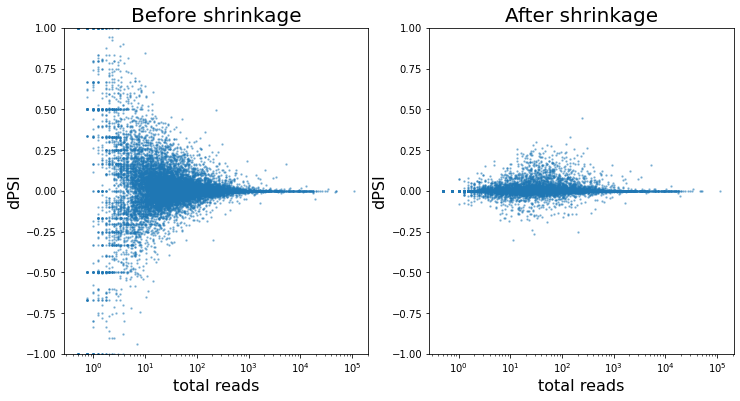

In [ ]:
pyplot.figure(figsize=(12,6))
ax=pyplot. subplot(121)
pyplot.title('Before shrinkage', size=20)
pyplot.scatter(data.SE.totalreads,res_norm.SE.orig.dpsi, s=2, alpha=.4)
pyplot.xscale('log')
pyplot.xlabel('total reads', size=16)
pyplot.ylabel('dPSI', size=16)
pyplot.ylim(-1,1)
ax=pyplot. subplot(122, sharey=ax)

pyplot.title('After shrinkage', size=20)
pyplot.scatter(data.SE.totalreads,res_norm.SE.dpsi, s=2, alpha=.4)
pyplot.xscale('log')
pyplot.xlabel('total reads', size=16)
pyplot.ylabel('dPSI', size=16)
pyplot.ylim(-1,1)

However, this does not handle an unbalanced number of up and downregulated events particularly. An excess of positive effect sizes will led the model to expect an comparable extent of negative effect sizes. This will lead to a tendency to inflate the negative effect sizes and dampen the positive effect size.

### `halfnormal`: Asymmetric effect sizes

This problem can be sidestepped by instead using a mixture of halfnormal distributions. 

In [ ]:
res_halfnorm=shrink_rMATS(data, method='halfnormal')

This learns the proportion of upregulated and downregulated events, which intuitively is useful. However, it carries this forward into the inferred effect sizes by slightly shifting them toward the direction with more significant effects:

Text(0, 0.5, 'Proportion')

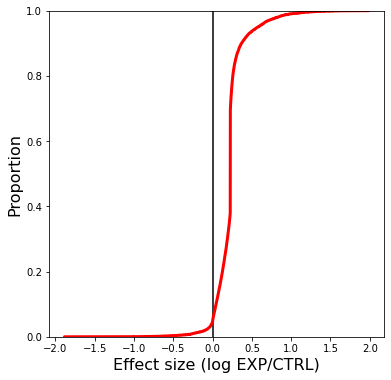

In [ ]:
pyplot.figure(figsize=(6,6))
pyplot.plot([0,0], [0,1], c='black')
seaborn.ecdfplot(res_halfnorm.SE.dphi, lw=3, c='r')
pyplot.xlabel('Effect size (log EXP/CTRL)', size=16)
pyplot.ylabel('Proportion', size=16)



Statistically, this is reasonable. The point estimates reflect the expected effect size. If we know that 80% of the inferred changes are upregulation and only 20% are downregulation, our expectations about any given effect size should be slightly biased toward positive values.

Because shrinkage pulls estimates derived from weak information toward the population mean, this manifests as a tendency for slightly positive delta PSI estimates for exons with low read counts.

(-0.4, 0.4)

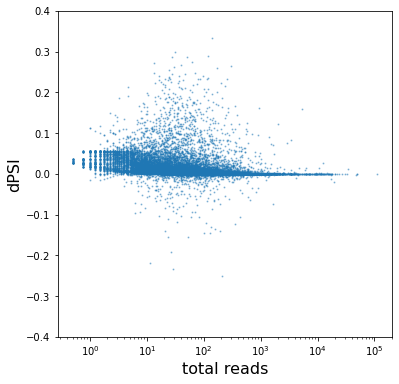

In [ ]:
pyplot.figure(figsize=(6,6))
pyplot.scatter(data.SE.totalreads,res_halfnorm.SE.dpsi, s=1, alpha=.4)
pyplot.xscale('log')
pyplot.xlabel('total reads', size=16)
pyplot.ylabel('dPSI', size=16)
pyplot.ylim(-.4,.4)

It also yields an unusual relationship between the original estimates and their shrinkage estimates:

Text(0.5, 0, 'Before shrinkage')

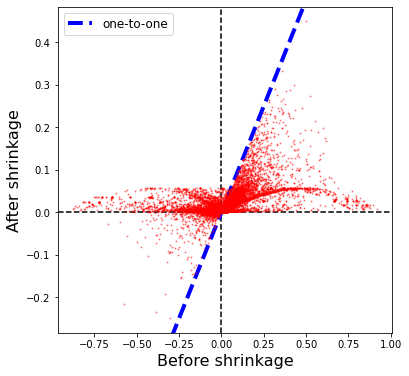

In [ ]:
pyplot.figure(figsize=(6,6))
pyplot.scatter(data.SE.dpsi,res_halfnorm.SE.dpsi, s=1, alpha=.4, c='r')
xlim=pyplot.xlim()
ylim=pyplot.ylim()
pyplot.plot([0,0], ylim, c='black', ls='--',zorder=-1)
pyplot.plot( xlim,[0,0], c='black', ls='--',zorder=-1)
max_bound=max(max(ylim), max(xlim))
min_bound=min(min(ylim), min(xlim))
pyplot.plot([min_bound, max_bound], [min_bound, max_bound], c='b', ls='--',lw=4, zorder=-1, label='one-to-one')
xlim=pyplot.xlim(xlim)
ylim=pyplot.ylim(ylim)
pyplot.legend(fontsize=12)
pyplot.ylabel('After shrinkage', size=16)
pyplot.xlabel('Before shrinkage', size=16)

While the statistical interpretation that our expectations about effect size may favor positive or negative values is principled, it can make interpretating and communicating the effect sizes more challenging. We may instead wish to more explicitly assume sparsity.

### `split`: Sparse, asymmetric effect sizes


To side step this we shrink the positive and negative effect sizes separately, using a normal mixture for each.

In [ ]:
res_split=shrink_rMATS(data, method='split')

Similar to the normal mixture, this pulls effect sizes estimates from weak evidence toward zero. But like the halfnormal mixture, it better respects potentially unbalanced numbers of positiive and negative effects.

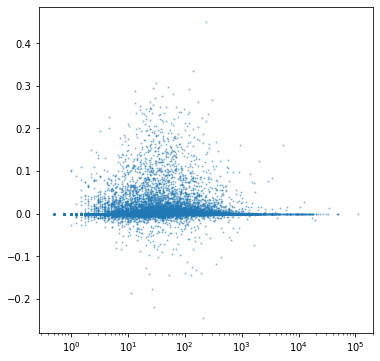

In [ ]:
pyplot.figure(figsize=(6,6))
pyplot.scatter(data.SE.totalreads,res_split.SE.dpsi, s=1, alpha=.4)
pyplot.xscale('log')

Unlike the halfnormal approach, this applies shrinkage in a much more regular manner. Weak evidence results in effect sizes near zero, rather than yield curved relationships with the original effect sizes.

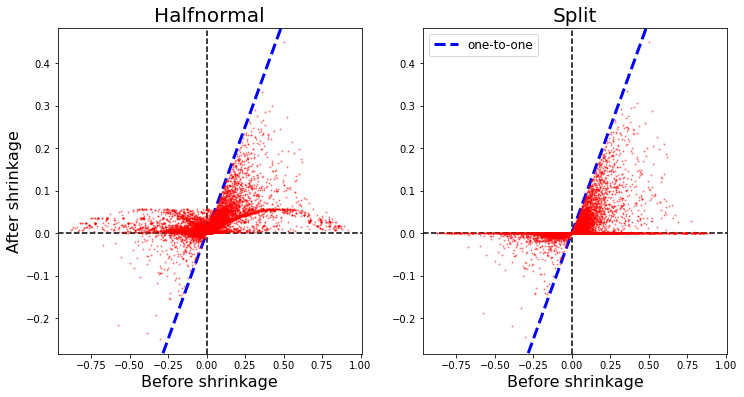

In [ ]:
pyplot.figure(figsize=(12,6))
ax=pyplot. subplot(121)
pyplot.title('Halfnormal', size=20)
pyplot.scatter(data.SE.dpsi,res_halfnorm.SE.dpsi,c='r', s=1, alpha=.4)
xlim=pyplot.xlim()
ylim=pyplot.ylim()
pyplot.plot([0,0], ylim, c='black', ls='--',zorder=-1)
pyplot.plot( xlim,[0,0], c='black', ls='--',zorder=-1)
max_bound=max(max(ylim), max(xlim))
min_bound=min(min(ylim), min(xlim))
pyplot.plot([min_bound, max_bound], [min_bound, max_bound], c='b',lw=3, ls='--', zorder=-1)
xlim=pyplot.xlim(xlim)
ylim=pyplot.ylim(ylim)
pyplot.ylabel('After shrinkage', size=16)
pyplot.xlabel('Before shrinkage', size=16)
ax=pyplot. subplot(122, sharey=ax)
pyplot.title('Split', size=20)

pyplot.scatter(data.SE.dpsi,res_split.SE.dpsi,c='r', s=1, alpha=.4)
xlim=pyplot.xlim()
ylim=pyplot.ylim()
pyplot.plot([0,0], ylim, c='black', ls='--',zorder=-1)
pyplot.plot( xlim,[0,0], c='black', ls='--',zorder=-1)
max_bound=max(max(ylim), max(xlim))
min_bound=min(min(ylim), min(xlim))
pyplot.plot([min_bound, max_bound], [min_bound, max_bound], c='b',lw=3, ls='--', zorder=-1, label='one-to-one')
pyplot.xlabel('Before shrinkage', size=16)
pyplot.legend(fontsize=12)

xlim=pyplot.xlim(xlim)
ylim=pyplot.ylim(ylim)

Again, comparing the three, `normal` and `split` yield similar results, though it estimates larger negative effect sizes and slightly smaller positive effect sizes than `split`. The `halfnormal` approach correctly concludes that there is a tendency toward positive effects, but it allows this to influence all of the effect size estimates. This is statistically reasonable, reflecting the knowledge that there are more positive effects. However, it seems more biologically reasonable to assume that most exons are truly unaffected and enforce sparsity in the point estimates. The `split` option accomplishes this well.

(-0.2, 0.2)

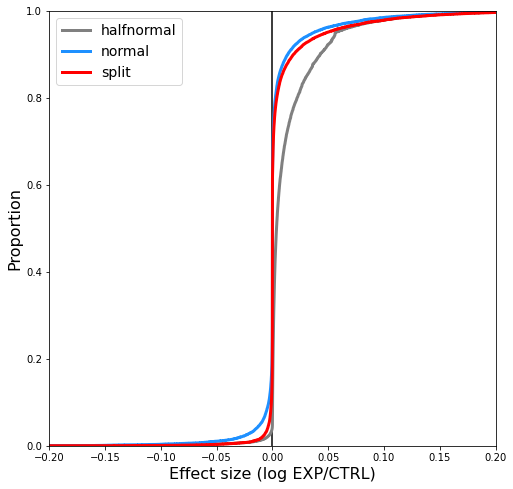

In [ ]:
pyplot.figure(figsize=(8,8))
pyplot.plot([0,0], [0,1], c='black')
seaborn.ecdfplot(res_halfnorm.SE.dpsi, lw=3, c='grey', label='halfnormal')
seaborn.ecdfplot(res_norm.SE.dpsi, lw=3, c='dodgerblue', label='normal')
seaborn.ecdfplot(res_split.SE.dpsi, lw=3, c='r',ls='-', label='split')
pyplot.legend(fontsize=14, loc=2)
pyplot.xlabel('Shrinkage estimate')
pyplot.xlabel('Effect size (log EXP/CTRL)', size=16)
pyplot.ylabel('Proportion', size=16)

pyplot.xlim(-.2, .2)

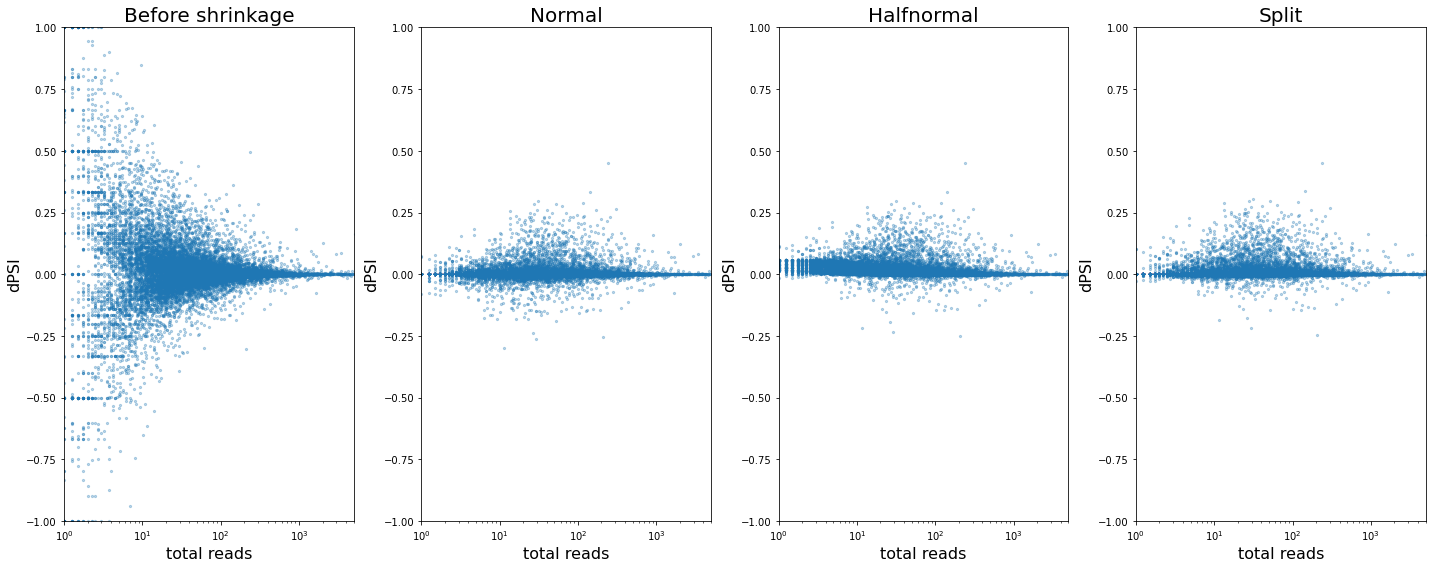

In [ ]:
pyplot.figure(figsize=(20,8))
size=5
alpha=.3
ax=pyplot. subplot(141)
pyplot.title('Before shrinkage', size=20)
pyplot.scatter(data.SE.totalreads,res_norm.SE.orig.dpsi, s=size, alpha=alpha)
pyplot.xscale('log')
pyplot.xlabel('total reads', size=16)
pyplot.ylabel('dPSI', size=16)
pyplot.ylim(-1,1)
ax=pyplot. subplot(142, sharey=ax, sharex=ax)

pyplot.title('Normal', size=20)
pyplot.scatter(data.SE.totalreads,res_norm.SE.dpsi, s=size, alpha=alpha)
pyplot.xscale('log')
pyplot.xlabel('total reads', size=16)
pyplot.ylabel('dPSI', size=16)
pyplot.ylim(-1,1)
ax=pyplot. subplot(143, sharey=ax, sharex=ax)

pyplot.title('Halfnormal', size=20)
pyplot.scatter(data.SE.totalreads,res_halfnorm.SE.dpsi, s=size, alpha=alpha)
pyplot.xscale('log')
pyplot.xlabel('total reads', size=16)
pyplot.ylabel('dPSI', size=16)
pyplot.ylim(-1,1)
ax=pyplot. subplot(144, sharey=ax, sharex=ax)

pyplot.title('Split', size=20)
pyplot.scatter(data.SE.totalreads,res_split.SE.dpsi, s=size, alpha=alpha)
pyplot.xscale('log')
pyplot.xlabel('total reads', size=16)
pyplot.ylabel('dPSI', size=16)
pyplot.ylim(-1,1)
pyplot.xlim(1, 5000)
pyplot.tight_layout()

We can use the inferred $94\%$ credible intervals from each approach to identify exons for which we are confident the effect size is nonzero. 

In [ ]:
sig_table={}
data_table={'No shrinkage': data,
    'Normal':res_norm,
    'Halfnormal':res_halfnorm,
           'Split':res_split}
for key, results in data_table.items():
    sig=numpy.sign(results.SE.dphi_lo)==numpy.sign(results.SE.dphi_hi)
    direction=numpy.sign(results.SE.dphi)
    upreg=sig&(direction>0)
    downreg=sig&(direction<0)
    unchanged=~upreg&~downreg
    sig_table[key]={'Downreg': downreg.sum(),
                   'Nonsig': unchanged.sum(),
                   'Upreg':upreg.sum()}
pd.DataFrame.from_dict(sig_table).T
    
    

Downreg  Nonsig  Upreg
No shrinkage      366   17084   1195
Normal             51   18261    333
Halfnormal         31   18241    373
Split              28   18222    395

Note that prior to shrinkage, this credible interval approach identifies nearly 1,400 significant exons, similar to the number of significant events using the rMATS pvalues without applying a multiple test correction.

In [ ]:
(data.SE.pval<.05).sum()

1483

Like a multiple test correction, `ashr` pools information across all effect size estimates to obtain the shrinkage estimates.